# RAFT

This notebook is adapted from https://github.com/princeton-vl/RAFT with quite some tweaks.

In [2]:
! git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 1 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 1.03 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [3]:
cd RAFT

/home/jovyan/RAFT


In [4]:
! mkdir -p models

In [5]:
cd models

/home/jovyan/RAFT/models


In [6]:
! wget https://raw.githubusercontent.com/vmware/vSphere-machine-learning-extension/master/examples/model_inference/cv/raft/models/raft-things.pth

--2023-09-20 11:03:58--  https://raw.githubusercontent.com/tiansiyuan/ML-models/master/raft/models/raft-things.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21108000 (20M) [application/octet-stream]
Saving to: ‘raft-things.pth’

raft-things.pth       1%[                    ] 407.44K   343 B/s    in 17m 10s 

2023-09-20 11:21:11 (405 B/s) - Connection closed at byte 417223. Retrying.

--2023-09-20 11:21:12--  (try: 2)  https://raw.githubusercontent.com/tiansiyuan/ML-models/master/raft/models/raft-things.pth
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 21108000 (20M), 20690777 (20M) remaining [application/octet-stream]
Saving to: 

In [7]:
cd ..

/home/jovyan/RAFT


The code below is adapted from demo.py.

In [8]:
%matplotlib inline
%matplotlib widget

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


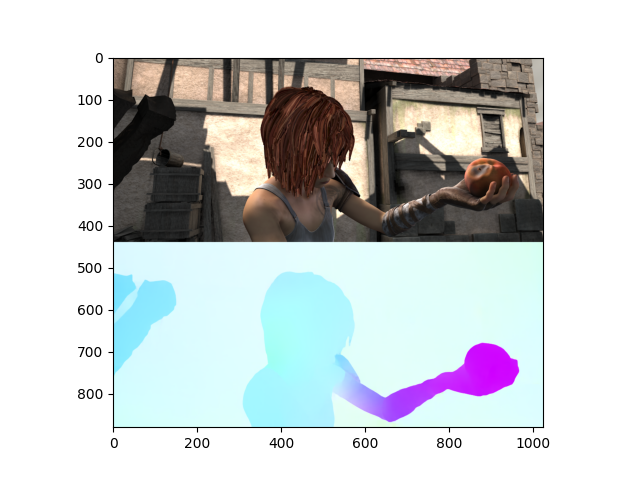

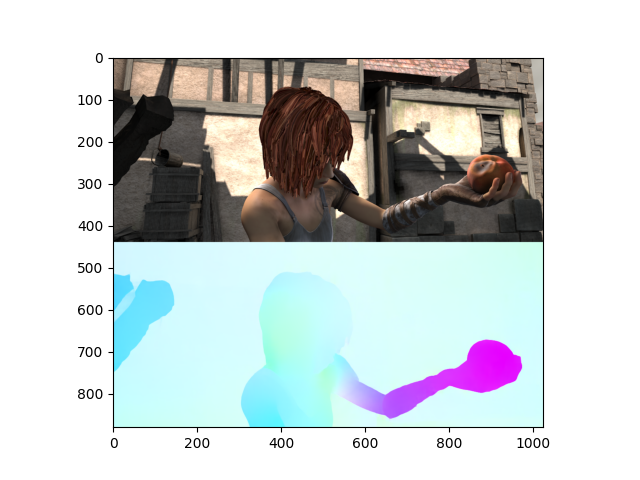

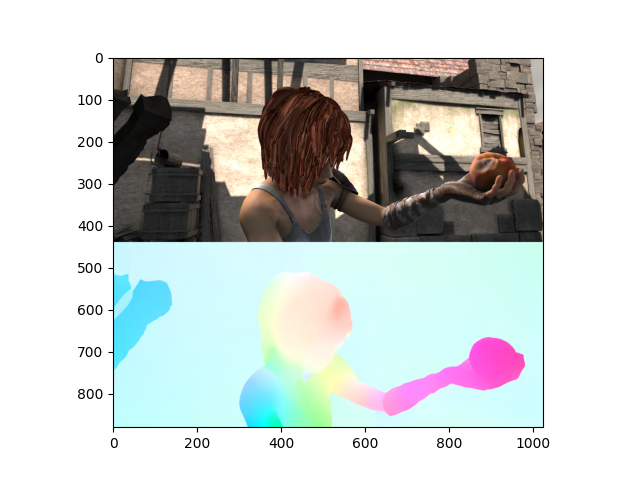

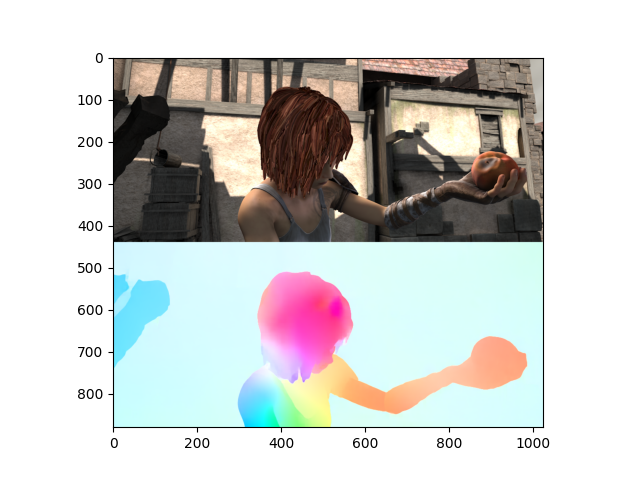

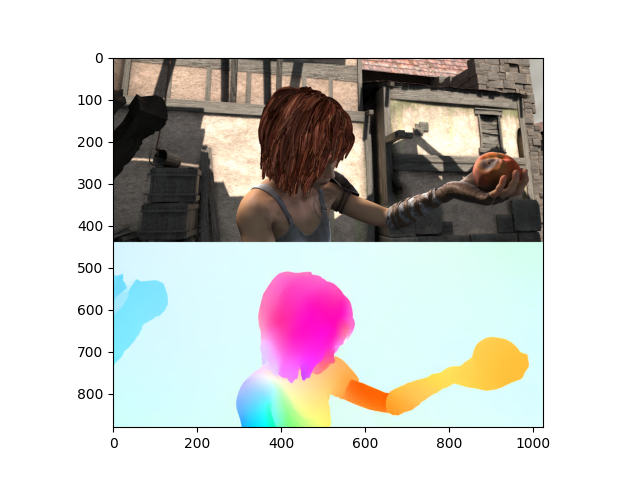

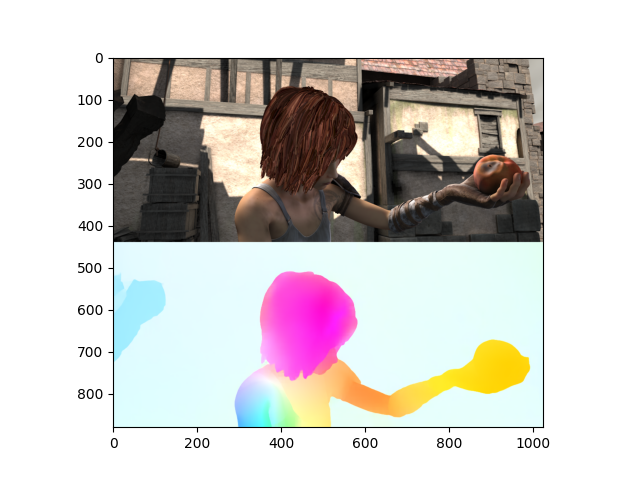

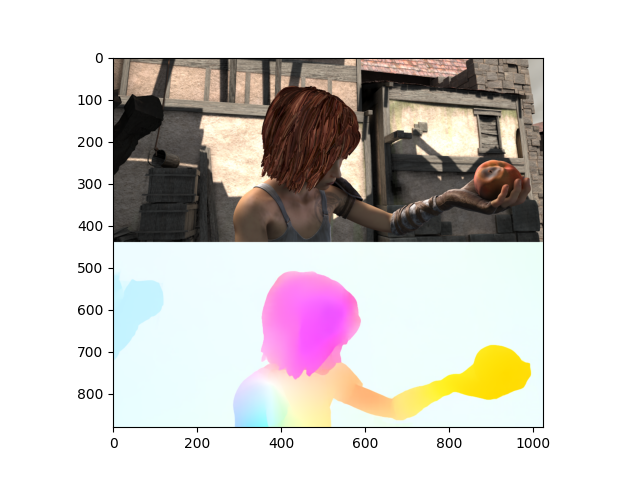

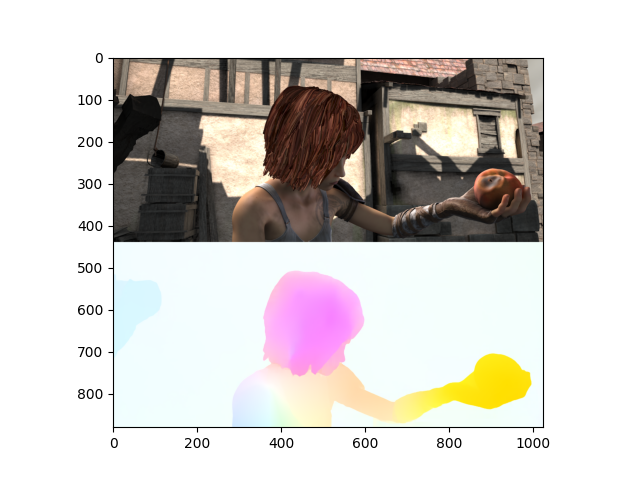

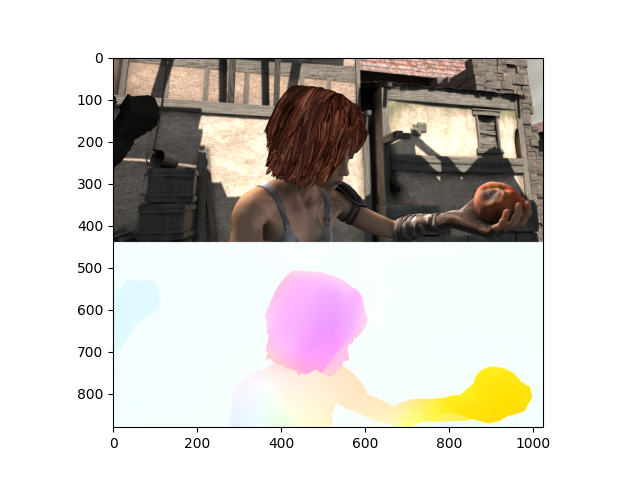

In [9]:
import sys
sys.path.append('core')

import argparse
import os
# import cv2
import glob
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



DEVICE = 'cuda' # Using GPU
# DEVICE = 'cpu' # Using CPU

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    # import matplotlib.pyplot as plt
    plt.imshow(img_flo / 255.0)
    plt.show()

    # cv2.imshow('image', img_flo[:, :, [2,1,0]]/255.0)
    # cv2.waitKey()

def demo(args):
    model = torch.nn.DataParallel(RAFT(args))
    # model.load_state_dict(torch.load(args.model)) using GPU
    model.load_state_dict(torch.load(args.model, map_location=torch.device('cpu'))) # Using CPU

    model = model.module
    model.to(DEVICE)
    model.eval()

    with torch.no_grad():
        images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))

        images = sorted(images)
        for imfile1, imfile2 in zip(images[:-1], images[1:]):
            image1 = load_image(imfile1)
            image2 = load_image(imfile2)

            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)

            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
            viz(image1, flow_up)

# model='models/raft-things.pth', path='demo-frames', small=False, mixed_precision=False, alternate_corr=False

class Args(argparse.Namespace):
  model = 'models/raft-things.pth'
  path = 'demo-frames'
  small = False
  mixed_precision = False
  alternate_corr = False

args=Args()

demo(args)